In [29]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/scratch/msc24h18/msc_project/aihwkit/src/')

plt.style.use('ggplot')

sys.path

['/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python311.zip',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11/lib-dynload',
 '',
 '/home/msc24h18/.local/lib/python3.11/site-packages',
 '/scratch/msc24h18/.conda/envs/aihwkit_dev/lib/python3.11/site-packages',
 '/scratch/msc24h18/msc_project/src',
 '/scratch/msc24h18/msc_project/aihwkit/src/',
 '/scratch/msc24h18/msc_project/aihwkit/src/',
 '/scratch/msc24h18/msc_project/aihwkit/src/']

In [30]:
WORKING_DIR = '/scratch/msc24h18/msc_project'
#FILE_PATH = 'data/LBE247_analyzed_2nd_run_only/LBE247_ID294YR/pulsedAmplitudeSweep_DCIV_20240919110921/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(2)]20240919111221/pulsedAmplitudeSweep_DCIV[LBE247_ID294YR(2)]20240919111221_Summary.dat'
FILE_PATH = '/scratch/msc24h18/msc_project/data/LBE247_analyzed_2nd_run_only/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919141831/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919142007/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919142007_Summary.dat'

data = pd.read_csv(os.path.join(WORKING_DIR, FILE_PATH), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,2,0.2,6.688963e+09,7.782101e+09
1,2,3,0.3,7.423905e+09,8.591065e+09
2,3,4,0.4,8.445946e+09,9.718173e+09
3,4,5,0.5,1.017294e+10,1.153403e+10
4,5,6,0.6,1.168224e+10,1.315789e+10


Number of LTP pulses: 14
Number of LTD pulses: 14


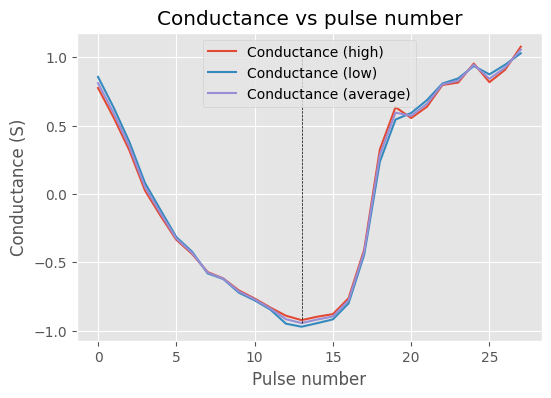

In [31]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2


def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())


conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

# ltp pulses are expected to be positive for fitting to work
pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']])
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

In [32]:
from aihwkit.utils.fitting import fit_measurements


def fit_model(device_config):
    params = {'dw_min': (0.1, 0.001, 1.0),
              'up_down': (0.0, -0.99, 0.99),
              'w_max': (1.0, 0.1, 2.0),
              'w_min': (-1.0, -2.0, -0.1),
              }

    result, device_config_fit, best_model_fit = fit_measurements(
        params,
        pulses,
        conductance,
        device_config)

    print(device_config_fit)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(conductance, label='Measured')
    ax.plot(best_model_fit, label='Fit')
    ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
    ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title=str(device_config))
    ax.legend()
    plt.show()

    # return result, device_config_fit, best_model_fit

ConstantStepDevice(
    dw_min=0.24297407383844774,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.16159611319898848,
    up_down_dtod=0.0,
    w_max=0.8993423801115841,
    w_max_dtod=0.0,
    w_min=-0.9147157391653231,
    w_min_dtod=0.0
)


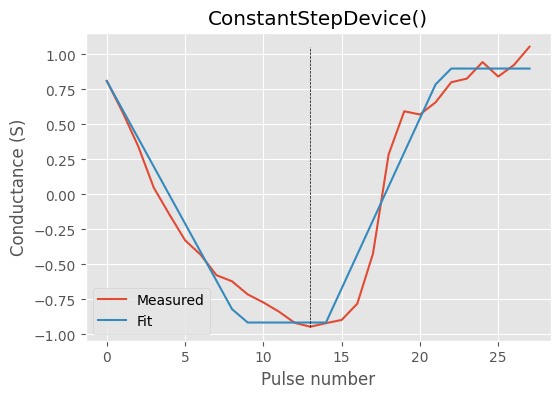

ExpStepDevice(
    dw_min=0.24774207308658283,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.1564327145132114,
    up_down_dtod=0.0,
    w_max=0.8971138019491413,
    w_max_dtod=0.0,
    w_min=-0.9176418592413782,
    w_min_dtod=0.0
)


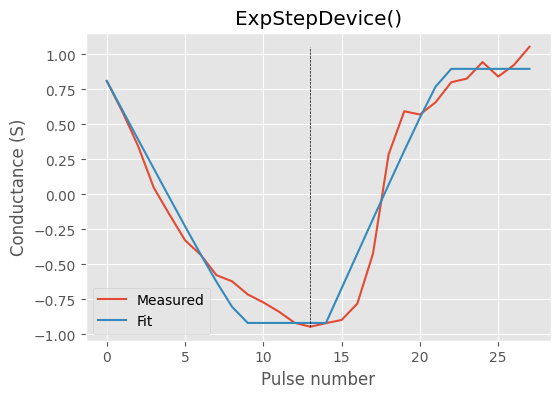

LinearStepDevice(
    dw_min=0.24297407383844774,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.16159611319898848,
    up_down_dtod=0.0,
    w_max=0.8993423801115841,
    w_max_dtod=0.0,
    w_min=-0.9147157391653231,
    w_min_dtod=0.0,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0
)


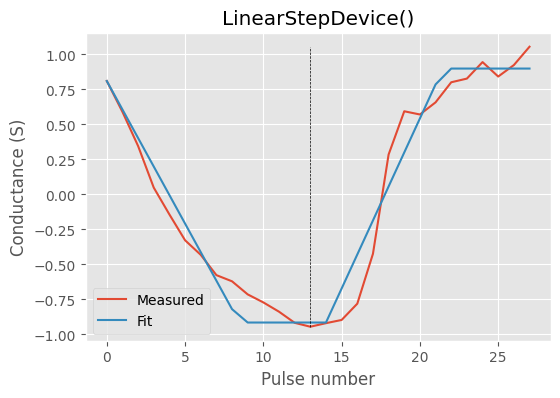

PowStepDevice(
    dw_min=0.4128198300364728,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.14638338447137067,
    up_down_dtod=0.0,
    w_max=1.4028708114088866,
    w_max_dtod=0.0,
    w_min=-1.4041008344280357,
    w_min_dtod=0.0,
    pow_gamma_dtod=0.0
)


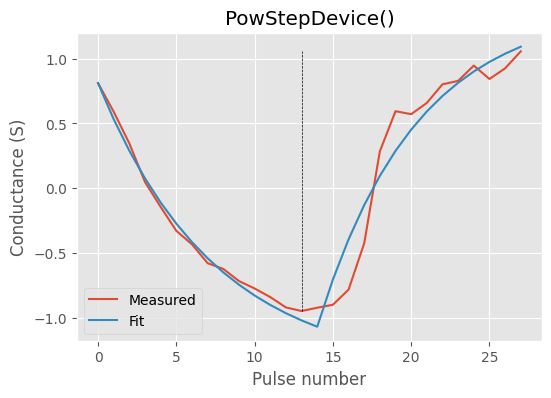

SoftBoundsDevice(
    dw_min=0.2077614049959772,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.15389032556785187,
    up_down_dtod=0.0,
    w_max=1.3730469199224735,
    w_max_dtod=0.0,
    w_min=-1.435291894857644,
    w_min_dtod=0.0
)


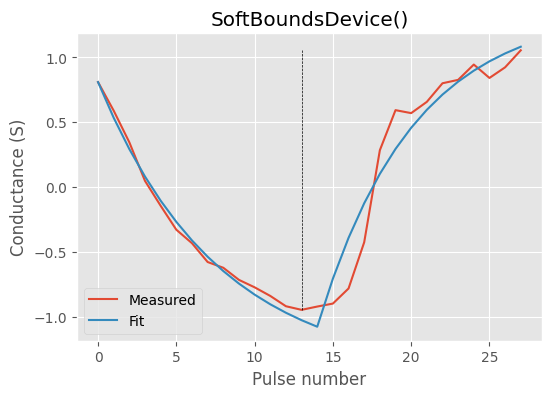

In [33]:
from aihwkit.simulator.configs import (
    ConstantStepDevice,
    ExpStepDevice,
    LinearStepDevice,
    PowStepDevice,
    SoftBoundsDevice
)

fit_model(ConstantStepDevice())
fit_model(ExpStepDevice())
fit_model(LinearStepDevice())
fit_model(PowStepDevice())
fit_model(SoftBoundsDevice())

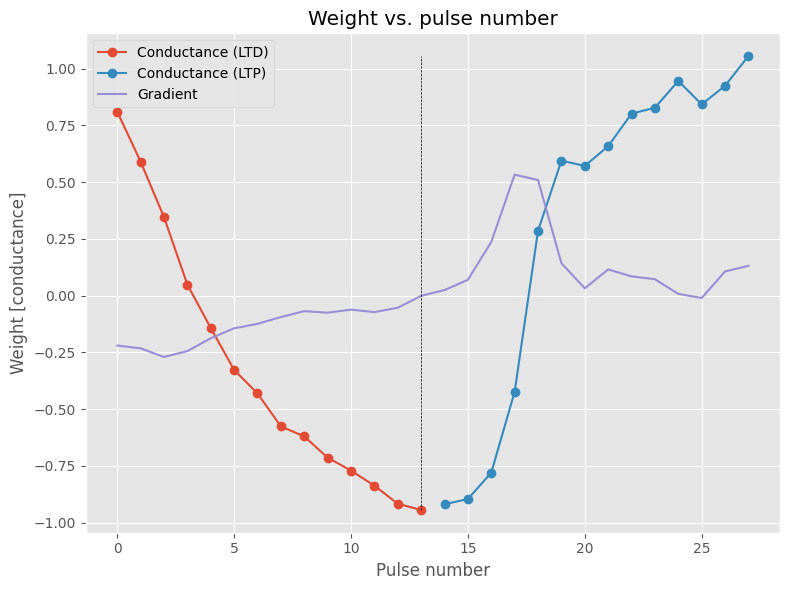

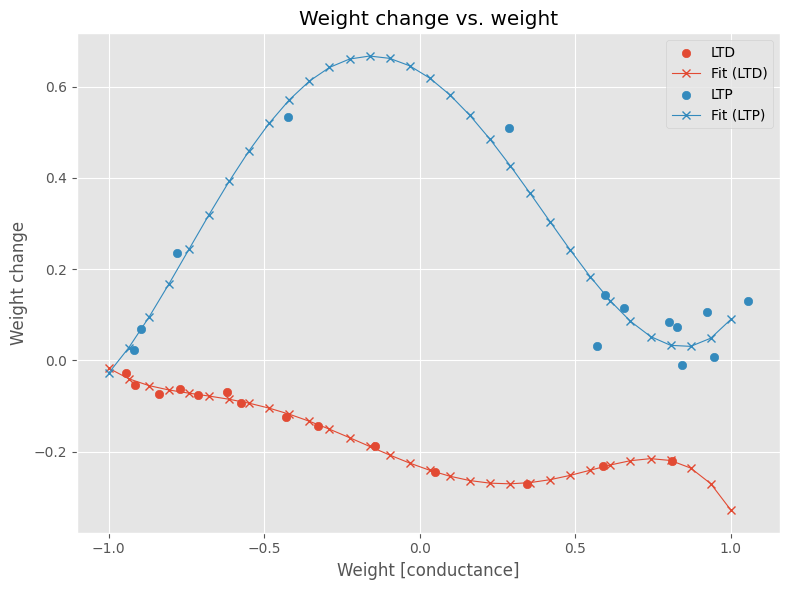

In [34]:
from numpy.polynomial.polynomial import Polynomial
pulses_ltp = np.where(pulses == 1)[0]
pulses_ltd = np.where(pulses == -1)[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pulses_ltd, conductance_ltd, label='Conductance (LTD)', marker='o')
ax.plot(pulses_ltp, conductance_ltp, label='Conductance (LTP)', marker='o')
# ax.plot(conductance)
ax.plot(np.gradient(conductance), label='Gradient')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Weight [conductance]", title="Weight vs. pulse number")
ax.legend()
plt.tight_layout()
#plt.savefig('tmp1.png')
plt.show()

grad_ltd = np.gradient(conductance_ltd)
grad_ltp = np.gradient(conductance_ltp)

fit_degree = 5
fit_grad_ltd = Polynomial.fit(conductance_ltd, grad_ltd, fit_degree)
fit_grad_ltp = Polynomial.fit(conductance_ltp, grad_ltp, fit_degree)

#xvals = np.linspace(conductance.min(), conductance.max(), 100)
xvals = np.linspace(-1, 1, 32)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(conductance_ltd, grad_ltd, label='LTD', color='C0')
ax.plot(xvals, fit_grad_ltd(xvals), label='Fit (LTD)', color='C0', lw=0.8, marker='x')

ax.scatter(conductance_ltp, grad_ltp, label='LTP', color='C1')
ax.plot(xvals, fit_grad_ltp(xvals), label='Fit (LTP)', color='C1', lw=0.8, marker='x')

ax.set(xlabel="Weight [conductance]", ylabel="Weight change", title="Weight change vs. weight")
ax.legend()
plt.tight_layout()
# plt.savefig('tmp2.png')
plt.show()

PiecewiseStepDevice(
    dw_min=0.2555652092860994,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.1326815790136766,
    up_down_dtod=0.0,
    w_max=0.9686459010677769,
    w_max_dtod=0.0,
    w_min=-1.1688608156489062,
    w_min_dtod=0.0,
    piecewise_up=[
        0.10606587850673646,
        0.10648275094280757,
        0.3601021530157828,
        0.639097634654137,
        0.929516703772506,
        1.2190931039037185,
        1.497190848844313,
        1.7547482573000355,
        1.9842219875313545,
        2.1795310719989693,
        2.3360009520093175,
        2.450307512360082,
        2.5204211159857026,
        2.5455506386028808,
        2.5260875033560932,
        2.463549715463095,
        2.360525896860431,
        2.220619320848945,
        2.0483919467392853,
        1.8493084544974157,
        1.629680279390125,
        1.396609646630532,
        1.157933606023595,
        0.9221680666116242,
        0.6984518313197847,
        0.496490631601

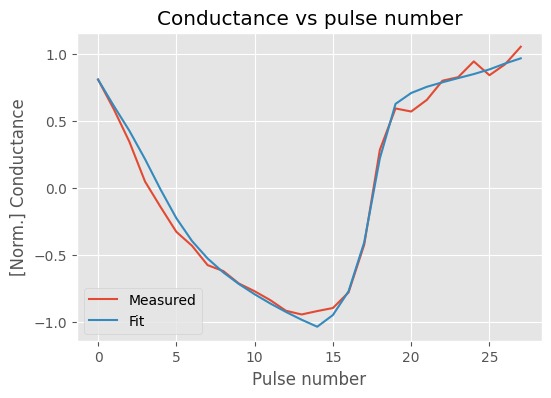

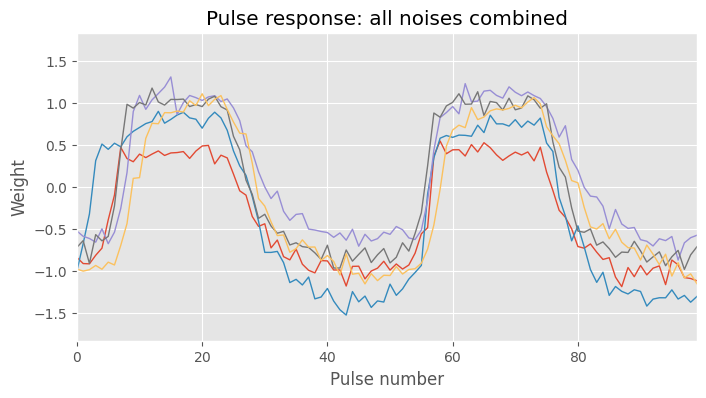

In [44]:
from aihwkit.utils.visualization import get_tile_for_plotting, compute_pulse_response
from aihwkit.simulator.configs import build_config
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import PiecewiseStepDevice
from aihwkit.utils.visualization import plot_device_compact

condvals = np.linspace(-1, 1, 32)
fit_ltp_vals = np.abs(fit_grad_ltp(condvals))
fit_ltd_vals = np.abs(fit_grad_ltd(condvals))

params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, pw_device_fit, pw_device_response = fit_measurements(
    params,
    pulses,
    conductance,
    PiecewiseStepDevice(
        piecewise_up=list(fit_ltp_vals),
        piecewise_down=list(fit_ltd_vals)
    ))

# rescale dw_min and conductance gradient
scale = (np.mean(fit_ltp_vals) + np.mean(fit_ltd_vals)) / 2
pw_device_fit.dw_min *= scale
pw_device_fit.piecewise_up = list(fit_ltp_vals / scale)
pw_device_fit.piecewise_down = list(fit_ltd_vals / scale)

print(pw_device_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(pw_device_response, label='Fit')
ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title="Conductance vs pulse number")
ax.legend()
plt.show()

pw_device_fit.dw_min_dtod = 0.3
pw_device_fit.dw_min_std = 0.3
pw_device_fit.w_min_dtod = 0.3
pw_device_fit.w_max_dtod = 0.3
pw_device_fit.write_noise_std = 0.3
pw_device_fit.up_down_dtod = 0

rpu_config = build_config('sgd', pw_device_fit)

fig, ax = plt.subplots(figsize=(8, 4))
ax = plot_device_compact(pw_device_fit, n_steps=25, n_traces=5, n_loops=2, axes=ax);
ax.set(xlabel="Pulse number", ylabel="Weight", title="Pulse response: all noises combined")

plt.savefig('tmp.png')
plt.show()